In [1]:
# Importamos las librerías necesarias
import os
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.stats import mode
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import cv2



def generar_patches_solapados(imagen, tamano=150, stride=50):
    """
    Divide la imagen en parches RGB con o sin solapamiento.

    Parámetros:
    - imagen: array (alto, ancho, 3)
    - tamano: tamaño del parche en píxeles (default=200)
    - stride: cantidad de píxeles entre parches (default=200). Si stride < tamano hay solapamiento.

    Retorna:
    - lista de parches (cada uno es un array (tamano, tamano, 3))
    """
    alto, ancho, _ = imagen.shape
    parches = []

    for y in range(0, alto - tamano + 1, stride):
        for x in range(0, ancho - tamano + 1, stride):
            parche = imagen[y:y+tamano, x:x+tamano]
            parches.append(parche)

    print(f"Se generaron {len(parches)} parches de {tamano}x{tamano} con stride {stride}")
    return parches

def construir_vectores_caracteristicas(parches, bins=256):
    """
    Construye vectores de características a partir de histogramas RGB de cada parche.

    Parámetros:
    - parches: lista de arrays (alto, ancho, 3)
    - bins: número de bins por histograma (por defecto 256)

    Retorna:
    - X: array numpy de forma (n_patches, bins * 3)
    """
    caracteristicas = []

    for parche in parches:
        vector = []
        for i in range(3):  # R, G, B
            hist, _ = np.histogram(parche[:, :, i], bins=bins, range=(0, 256), density=True)
            vector.extend(hist)
        caracteristicas.append(vector)

    X = np.array(caracteristicas)
    print(f"Se construyó una matriz de características con forma: {X.shape}")
    return X


def aplicar_kmeans(X, n_clusters=4, random_state=42):
    """
    Aplica K-Means sobre la matriz de características.

    Parámetros:
    - X: array de forma (n_patches, n_features)
    - n_clusters: número de grupos a generar
    - random_state: semilla para reproducibilidad

    Retorna:
    - labels: array con la etiqueta de cluster para cada parche
    - modelo_kmeans: el objeto KMeans entrenado
    """
    print(f"Aplicando K-Means con {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state,)
    labels = kmeans.fit_predict(X)
    print("K-Means finalizado.")
    return labels, kmeans

def visualizar_histogramas_promedio(X, labels, bins=256):
    """
    Visualiza los histogramas promedio por clúster (una gráfica por clúster, con subgráficos R-G-B).

    Parámetros:
    - X: matriz de características (n_samples, 768)
    - labels: etiquetas de clúster
    - bins: número de bins usados en cada histograma
    """
    n_clusters = len(np.unique(labels))
    colores = ['red', 'green', 'blue']
    titulos = ['Rojo (R)', 'Verde (G)', 'Azul (B)']

    for cl in range(n_clusters):
        indices = np.where(labels == cl)[0]
        hist_cl = X[indices]  # Subconjunto del clúster
        promedio = hist_cl.mean(axis=0)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"Histograma promedio - Clúster {cl}", fontsize=14)

        for i in range(3):
            inicio = i * bins
            fin = (i + 1) * bins
            axes[i].plot(promedio[inicio:fin], color=colores[i])
            axes[i].set_title(titulos[i])
            axes[i].set_xlabel("Intensidad")
            axes[i].set_ylabel("Frecuencia")
            axes[i].set_xlim(0, bins - 1)

        plt.tight_layout()
        plt.show()


def visualizar_mapa_clusters_coloreado(imagen, modelo, tamano=200, stride=200, normalizar=True, alpha=0.4,clustersP=[1,2],Title="Mapa de clústeres sobre imagen",bins=256):
    """
    Visualiza la imagen original superpuesta con colores por clúster (con transparencia).

    Parámetros:
    - imagen: imagen RGB original (H x W x 3)
    - modelo: modelo KMeans entrenado
    - tamano: tamaño del parche (en píxeles)
    - stride: paso entre parches
    - normalizar: si se normaliza el histograma como en el entrenamiento
    - alpha: transparencia del overlay (0 a 1)
    - clustersP: Clusters para visualizar
    """
    alto, ancho, _ = imagen.shape
    cluster_map = np.zeros_like(imagen, dtype=np.uint8)

    # Paleta de colores por clúster
    np.random.seed(42)  # Semilla para colores consistentes
    colores_cluster = np.random.randint(0, 255, size=(len(clustersP), 3), dtype=np.uint8)

    for y in range(0, alto - tamano + 1, stride):
        for x in range(0, ancho - tamano + 1, stride):
            parche = imagen[y:y+tamano, x:x+tamano]
            if parche.shape[0] == tamano and parche.shape[1] == tamano:
                # Vector de histograma
                vector = []
                for i in range(3):
                    hist, _ = np.histogram(parche[:, :, i], bins=bins, range=(0, 256), density=normalizar)
                    vector.extend(hist)
                vector = np.array(vector).reshape(1, -1)
                vector=normalize(vector,"l2")
                # Predicción de clúster
                cluster = modelo.predict(vector)[0]
                

                # Pintamos el parche en el mapa de clúster
                if cluster in clustersP:
                    color = colores_cluster[clustersP.index(cluster)]
                    cluster_map[y:y+tamano, x:x+tamano] = color
                else:
                    cluster_map[y:y+tamano, x:x+tamano]=0


    # Mostrar imagen original + superposición de clúster
    plt.figure(figsize=(12, 12))
    plt.imshow(imagen)
    plt.imshow(cluster_map, alpha=alpha)
    plt.title(Title)
    plt.axis("off")
    plt.show()



def mostrar_ejemplos_cluster(parches, labels, cluster=0, max_muestras=10):
    """
    Muestra una galería de imágenes de ejemplo para un clúster específico.

    Parámetros:
    - parches: lista de arrays (cada uno es un parche RGB)
    - labels: etiquetas del clúster para cada parche
    - cluster: número de clúster a mostrar
    - max_muestras: cantidad de parches a mostrar (por defecto 10)
    """
    indices = np.where(labels == cluster)[0]
    
    if len(indices) == 0:
        print(f"No hay parches asignados al clúster {cluster}.")
        return

    muestras = indices[:max_muestras]  # Tomamos las primeras N
    n = len(muestras)

    cols = 5
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(f"{n} ejemplos del clúster {cluster}", fontsize=16)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        if i < n:
            ax.imshow(parches[muestras[i]])
            ax.set_title(f"Parche #{muestras[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def construir_vectores_caracteristicas_HSV(parches, bins=256):
    """
    Construye vectores de características a partir de histogramas HSV de cada parche.

    Parámetros:
    - parches: lista de arrays (H, W, 3) en formato HSV
    - bins: número de bins por histograma

    Retorna:
    - X: array (n_patches, bins * 3)
    """
    caracteristicas = []

    for parche in parches:
        vector = []

        # H (0–180)
        hist_H, _ = np.histogram(parche[:, :, 0], bins=int(bins*180/256), range=(0, 180), density=True)
        vector.extend(hist_H)

        # S y V (0–256)
        for i in [1, 2]:
            hist, _ = np.histogram(parche[:, :, i], bins=bins, range=(0, 256), density=True)
            vector.extend(hist)

        caracteristicas.append(vector)

    X = np.array(caracteristicas)
    print(f"Se construyó una matriz de características HSV con forma: {X.shape}")
    return X
import matplotlib.pyplot as plt


def visualizar_histogramas_promedio_HSV(X, labels, bins=256):
    """
    Visualiza los histogramas promedio por clúster en espacio HSV.

    Parámetros:
    - X: matriz de características (n_samples, bins*3)
    - labels: etiquetas de clúster
    - bins: número de bins por histograma
    """
    n_clusters = len(np.unique(labels))
    colores = ['purple', 'green', 'orange']
    titulos = ['Tono (H)', 'Saturación (S)', 'Brillo (V)']

    for cl in range(n_clusters):
        indices = np.where(labels == cl)[0]
        hist_cl = X[indices]
        promedio = hist_cl.mean(axis=0)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"Histograma promedio HSV - Clúster {cl}", fontsize=14)
        binsV=int(bins*180/256)
        for i in range(3):
            if i==0:
                inicio = i * binsV
                fin = (i + 1) * binsV
                axes[i].plot(promedio[inicio:fin], color=colores[i])
                axes[i].set_title(titulos[i])
                axes[i].set_xlabel("Intensidad")
                axes[i].set_ylabel("Frecuencia")
                axes[i].set_xlim(0, binsV - 1)
            else: 
                inicio = (i-1) * bins+binsV
                fin = (i) * bins+binsV
                axes[i].plot(promedio[inicio:fin], color=colores[i])
                axes[i].set_title(titulos[i])
                axes[i].set_xlabel("Intensidad")
                axes[i].set_ylabel("Frecuencia")
                axes[i].set_xlim(0, bins - 1)

        plt.tight_layout()
        plt.show()

def visualizar_mapa_clusters_coloreado_HSV(imagen_hsv, modelo, tamano=200, stride=200, normalizar=True,
                                           alpha=0.4, clustersP=[1, 2], Title="Mapa de clústeres HSV", bins=256):
    """
    Visualiza la imagen original RGB superpuesta con colores por clúster basado en características HSV.

    Parámetros:
    - imagen_hsv: imagen HSV original (H x W x 3)
    - modelo: modelo KMeans entrenado
    - tamano: tamaño del parche (en píxeles)
    - stride: paso entre parches
    - normalizar: normalizar los histogramas
    - alpha: transparencia del overlay
    - clustersP: Clústeres a mostrar
    - Title: título del gráfico
    - bins: número de bins por histograma
    """
    alto, ancho, _ = imagen_hsv.shape
    cluster_map = np.zeros((alto, ancho, 3), dtype=np.uint8)

    np.random.seed(42)
    colores_cluster = np.random.randint(0, 255, size=(len(clustersP), 3), dtype=np.uint8)

    for y in range(0, alto - tamano + 1, stride):
        for x in range(0, ancho - tamano + 1, stride):
            parche = imagen_hsv[y:y+tamano, x:x+tamano]
            if parche.shape[0] == tamano and parche.shape[1] == tamano:
                vector = []

                hist_H, _ = np.histogram(parche[:, :, 0], bins=int(bins*180/256), range=(0, 180), density=True)
                vector.extend(hist_H)

                for i in [1, 2]:
                    hist, _ = np.histogram(parche[:, :, i], bins=bins, range=(0, 256), density=True)
                    vector.extend(hist)

                vector = np.array(vector).reshape(1, -1)
                

                cluster = modelo.predict(vector)[0]

                if cluster in clustersP:
                    color = colores_cluster[clustersP.index(cluster)]
                    cluster_map[y:y+tamano, x:x+tamano] = color
                else:
                    cluster_map[y:y+tamano, x:x+tamano] = 0

    # Mostrar la imagen RGB original con el overlay
    imagen_rgb = cv2.cvtColor(imagen_hsv, cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(imagen_rgb)
    plt.imshow(cluster_map, alpha=alpha)
    plt.title(Title)
    plt.axis("off")
    plt.show()



def reconstruir_mapa_clusters(imagen,X, model, tamano=200, stride=100, cluster_prioritario=[0],umbral=2):
    """
    Reconstruye un mapa de etiquetas por pixel a partir de los parches, asignando por moda,
    pero con prioridad absoluta al clúster indicado si está presente en los votos.

    Parámetros:
    - imagen: array RGB (H x W x 3)
    - labels: lista de etiquetas (1 por parche)
    - tamano: tamaño del parche
    - stride: desplazamiento entre parches
    - cluster_prioritario: etiqueta a priorizar si está presente (por defecto 2)

    Retorna:
    - mapa_etiquetas: array 2D (H x W) con etiquetas por pixel
    """
    alto, ancho, _ = imagen.shape
    labels=model.predict(X)
    # Creamos una matriz de listas para almacenar los votos
    votos = np.empty((alto, ancho), dtype=object)
    for y in range(alto):
        for x in range(ancho):
            votos[y, x] = []

    index = 0
    for y in range(0, alto - tamano + 1, stride):
        for x in range(0, ancho - tamano + 1, stride):
            if index >= len(labels):
                break
            etiqueta = labels[index]
            for i in range(y, y + tamano):
                for j in range(x, x + tamano):
                    votos[i, j].append(etiqueta)
            index += 1
            #print(index)

    # Creamos el mapa final aplicando la prioridad
    mapa_etiquetas = np.zeros((alto, ancho), dtype=np.uint8)
    for y in range(alto):
        for x in range(ancho):
            
            if votos[y, x]:
                
                if sum([votos[y, x].count(cl) for cl in cluster_prioritario])>umbral :
                        mapa_etiquetas[y, x] = 1
                else:
                    mapa_etiquetas[y, x] = 0
            else:
                mapa_etiquetas[y, x] = 0  # sin voto
       
    return mapa_etiquetas

def visualizar_mapa_reconstruido(imagen, mapa_etiquetas, cluster_destacado=1, alpha=0.5, color_destacado=(255, 0, 0)):
    """
    Muestra la imagen con superposición solo del clúster deseado, en color y con transparencia.

    Parámetros:
    - imagen: array RGB original
    - mapa_etiquetas: array 2D (H x W) con etiquetas por pixel
    - cluster_destacado: número de clúster a mostrar
    - alpha: transparencia del overlay
    - color_destacado: tupla RGB para el color del clúster (por defecto rojo)
    """
    alto, ancho, _ = imagen.shape
    overlay = np.zeros((alto, ancho, 3), dtype=np.uint8)

    # Asignamos color solo donde el cluster coincide
    mascara = (mapa_etiquetas == cluster_destacado)
    overlay[mascara] = color_destacado

    # Mostrar con transparencia
    plt.figure(figsize=(12, 12))
    plt.imshow(imagen)
    plt.imshow(overlay, alpha=alpha)
    plt.title(f"Región del clúster {cluster_destacado}", fontsize=14)
    plt.axis("off")
    plt.show()


def dilatacion_mascara_cluster(mapa_clusters, cluster_id, kernel_size=3, iteraciones=1):
    """
    Aplica dilatación a la máscara binaria de un clúster específico.

    Parámetros:
    - mapa_clusters: array 2D con etiquetas por píxel
    - cluster_id: número del clúster a procesar
    - kernel_size: tamaño del elemento estructurante (default 3x3)
    - iteraciones: cantidad de dilataciones consecutivas

    Retorna:
    - mascara_dilatada: array binario 2D después de la dilatación
    """
    # Crear máscara binaria donde el cluster coincide
    mascara = (mapa_clusters == cluster_id).astype(np.uint8)

    # Crear kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Aplicar dilatación
    mascara_dilatada = cv2.dilate(mascara, kernel, iterations=iteraciones)

    return mascara_dilatada


def erosion_mascara_cluster(mapa_clusters, cluster_id, iteraciones=1,kernel = np.ones((3, 3), np.uint8)):
    """
    Aplica erosión a la máscara binaria de un clúster específico.

    Parámetros:
    - mapa_clusters: array 2D con etiquetas por píxel
    - cluster_id: número del clúster a procesar
    - kernel_size: tamaño del elemento estructurante (ej. 3)
    - iteraciones: cantidad de erosiones consecutivas

    Retorna:
    - mascara_erodida: array binario 2D después de la erosión
    """
    # Crear la máscara binaria
    mascara = (mapa_clusters == cluster_id).astype(np.uint8)

   
    # Aplicar erosión
    mascara_erodida = cv2.erode(mascara, kernel, iterations=iteraciones)

    return mascara_erodida

In [2]:
Ruta=r"C:\Users\EsSe009\citrus3-detector\data\database\train\png_high_res"
Xs=[]
archivos = [f for f in os.listdir(Ruta) if os.path.isfile(os.path.join(Ruta, f))]
Tam=40
Str=10
for imm in archivos:
    
    imagen_tiff = os.path.join(Ruta, imm)
    with rasterio.open(imagen_tiff) as src:

        imagen = src.read()
        imagen = np.transpose(imagen, (1, 2, 0))  # Reordenar a (alto, ancho, bandas)
        print(imagen.shape[1],imagen.shape[0])
        #imagen=cv2.resize(imagen, (imagen.shape[1]//4, imagen.shape[0]//4), interpolation=cv2.INTER_CUBIC)
    parches_rgb=generar_patches_solapados(imagen,Tam,Str)

    Xs.append( construir_vectores_caracteristicas(parches_rgb,32))
X_RGB=np.concatenate(Xs)



c:\Users\EsSe009\citrus3-detector\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2419 2396
Se generaron 56168 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (56168, 96)
2986 3024
Se generaron 88205 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (88205, 96)
2687 2572
Se generaron 67310 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (67310, 96)
3177 3124
Se generaron 97026 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (97026, 96)
3859 3629
Se generaron 137138 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (137138, 96)
3468 3262
Se generaron 110789 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (110789, 96)
3530 3468
Se generaron 120050 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (120050, 96)
3782 3889
Se generaron 144375 parches de 40x40 con stride 10
Se construyó una matriz de características con form

Aplicando K-Means con 15 clusters...
K-Means finalizado.


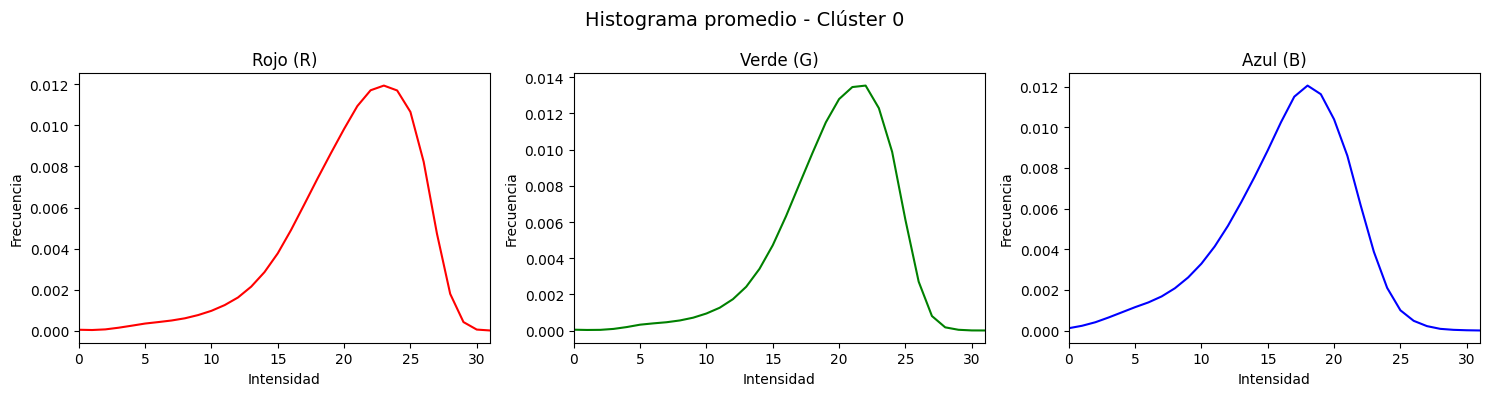

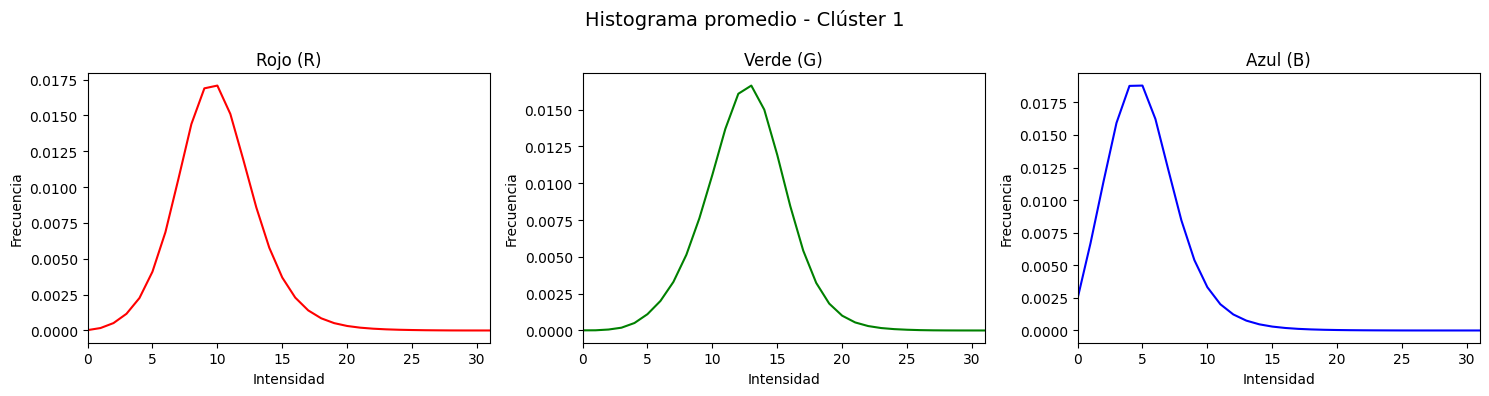

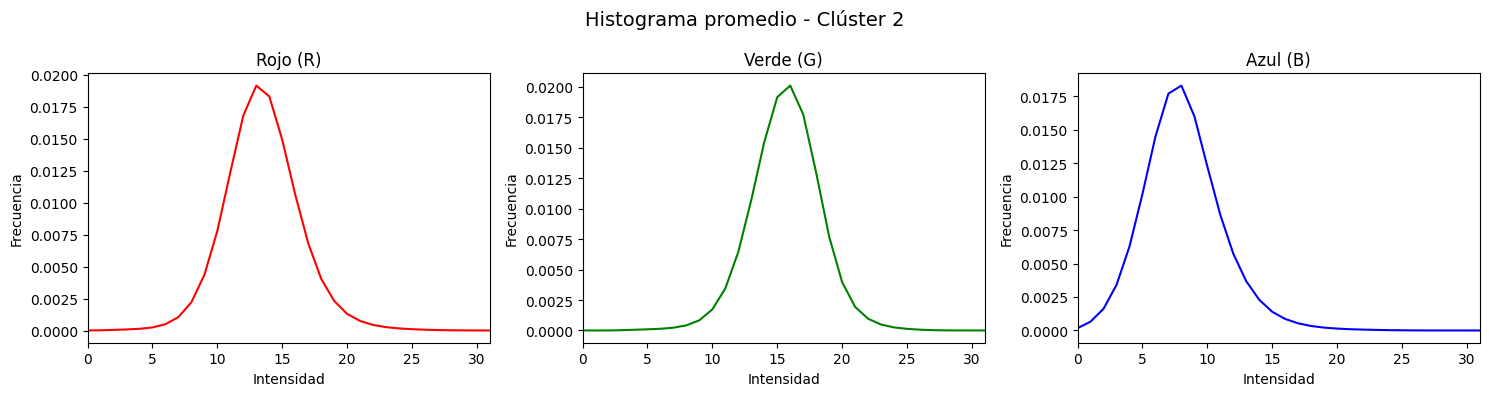

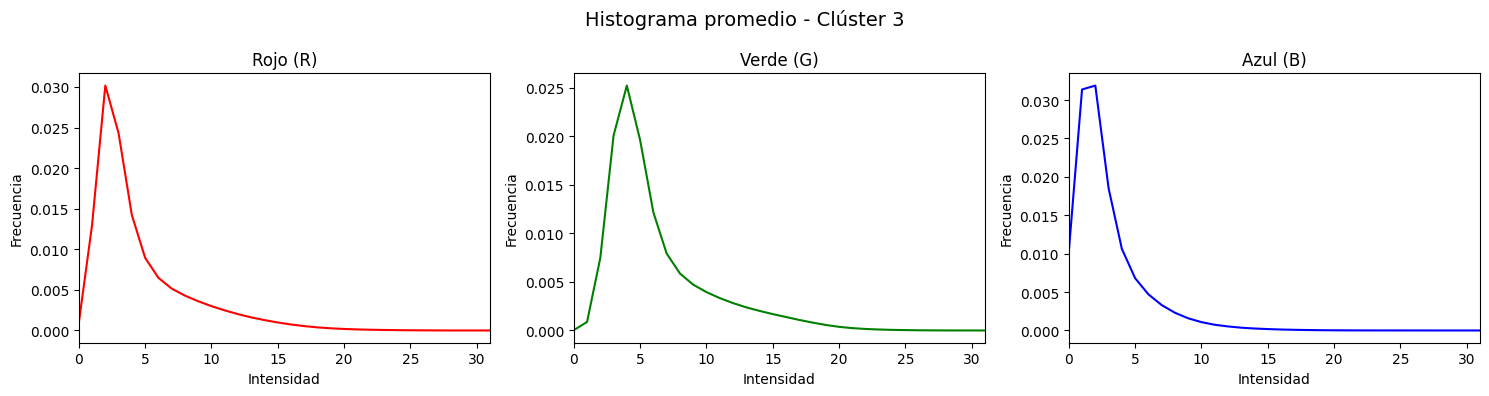

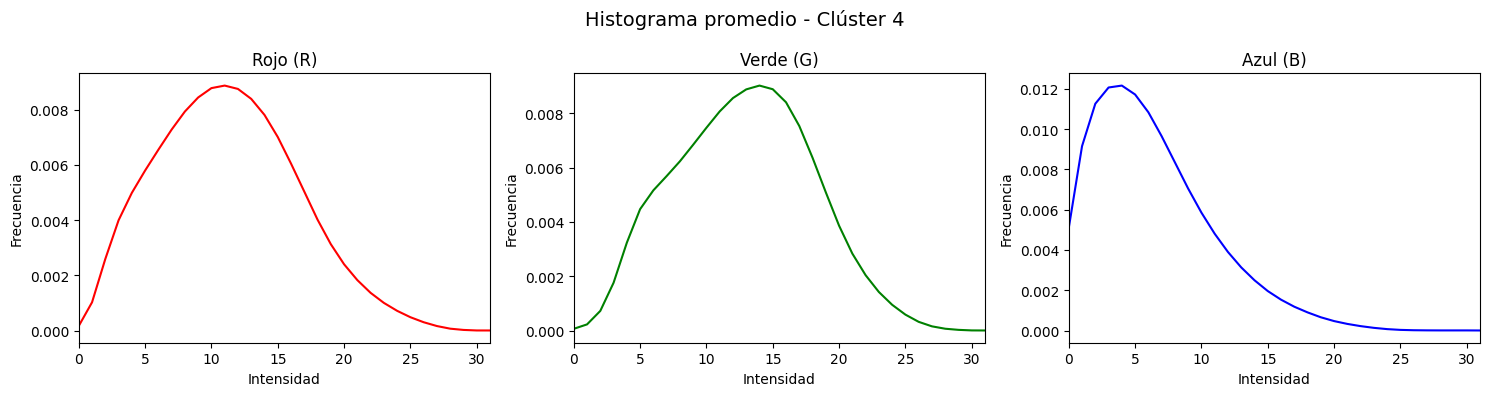

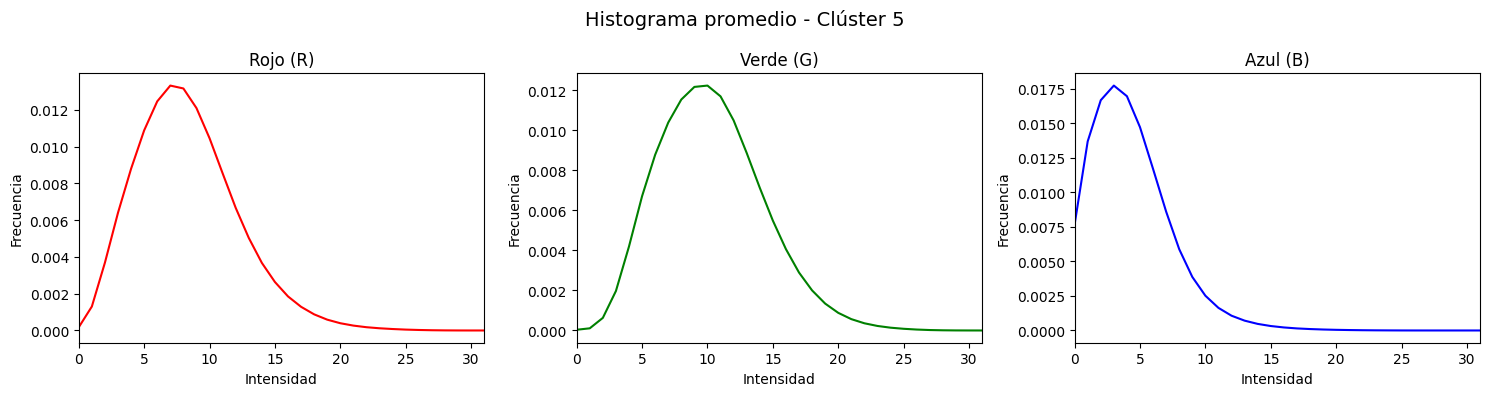

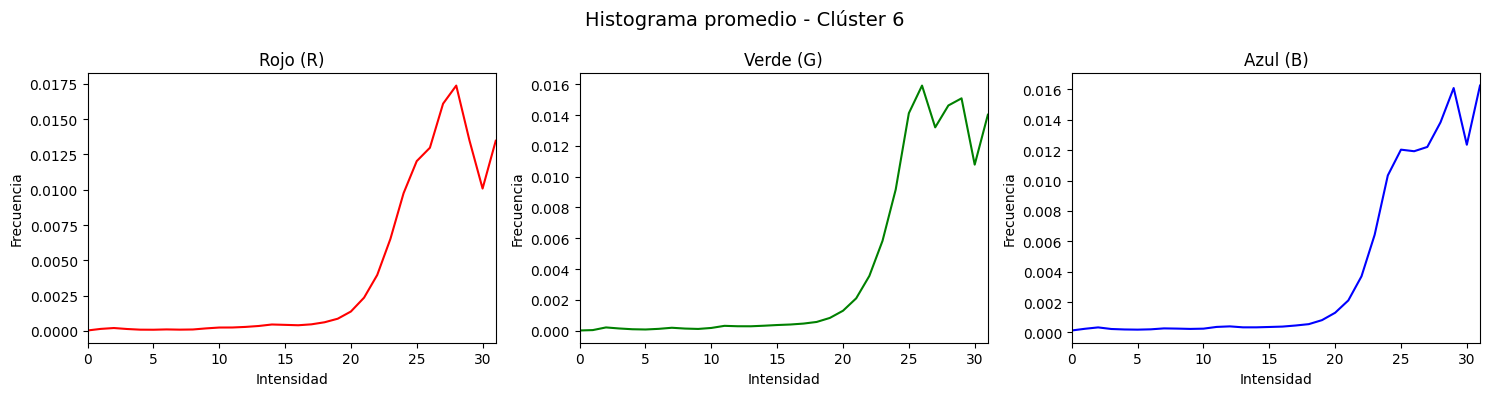

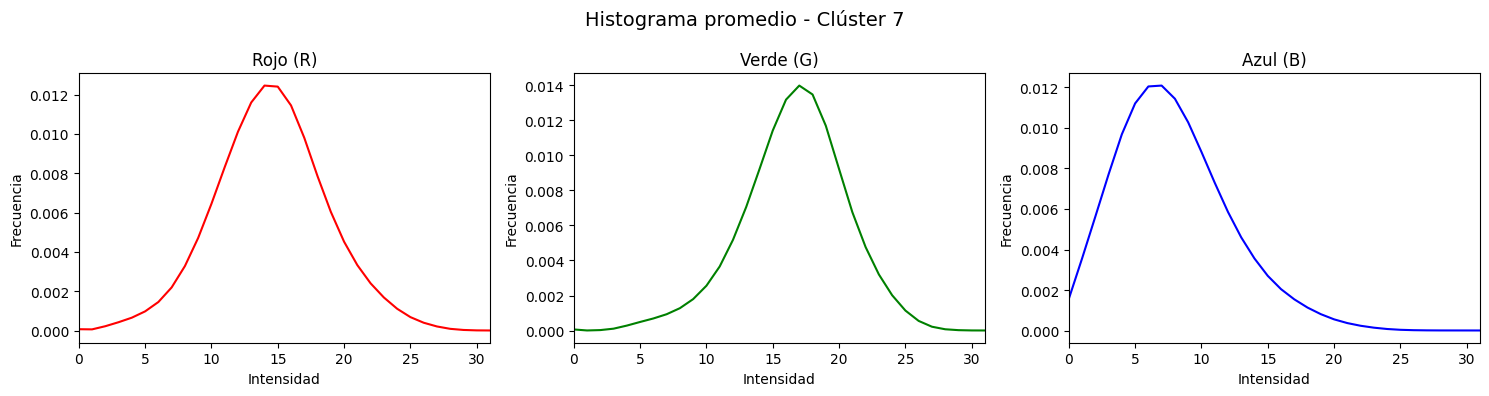

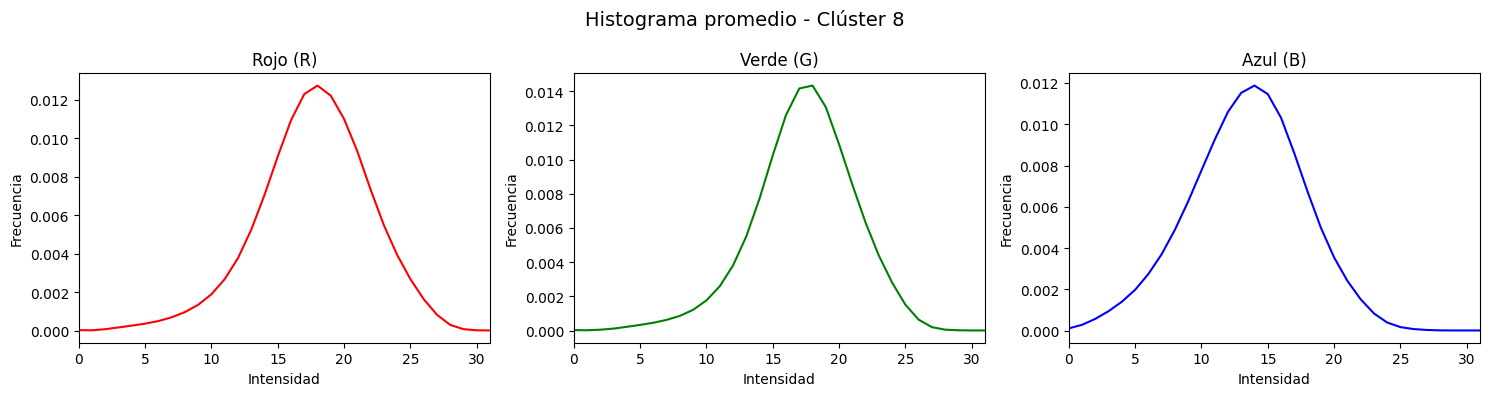

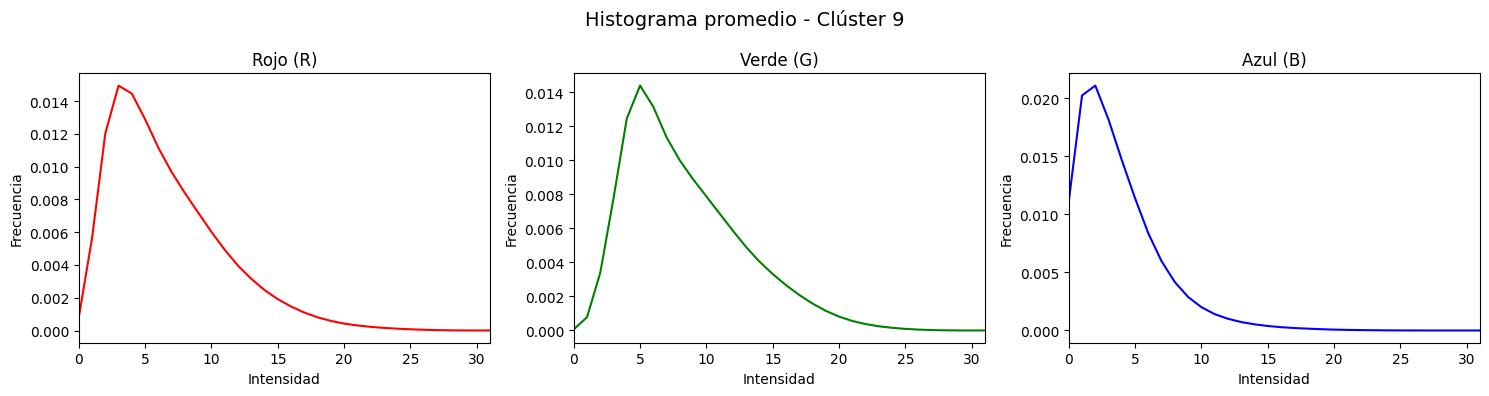

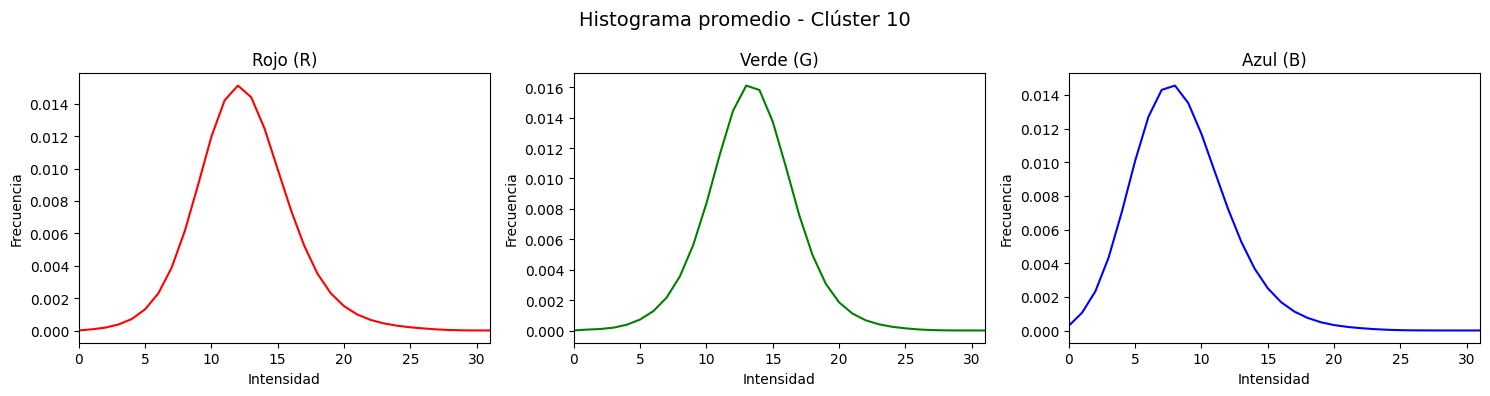

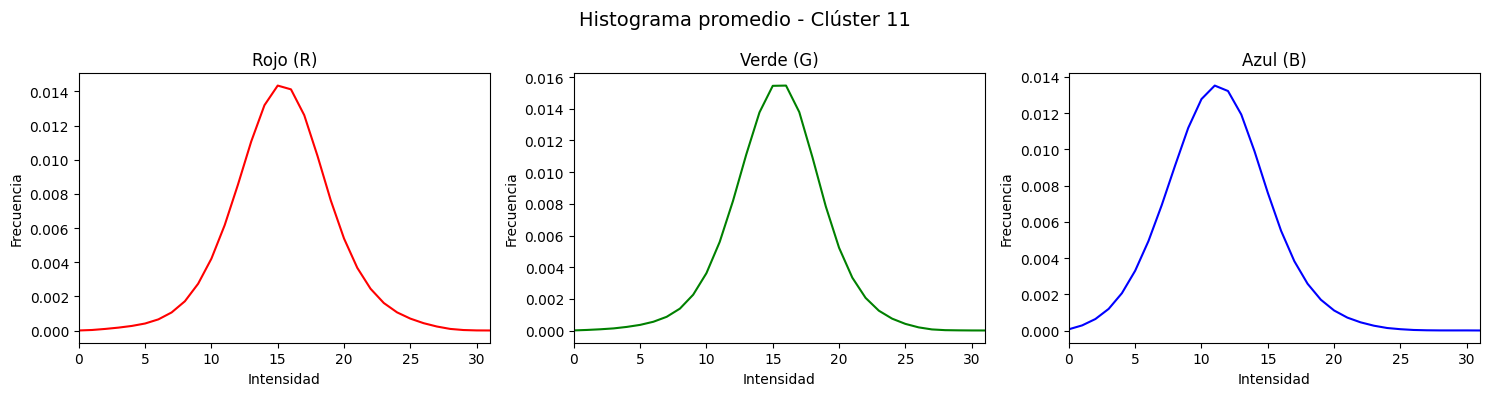

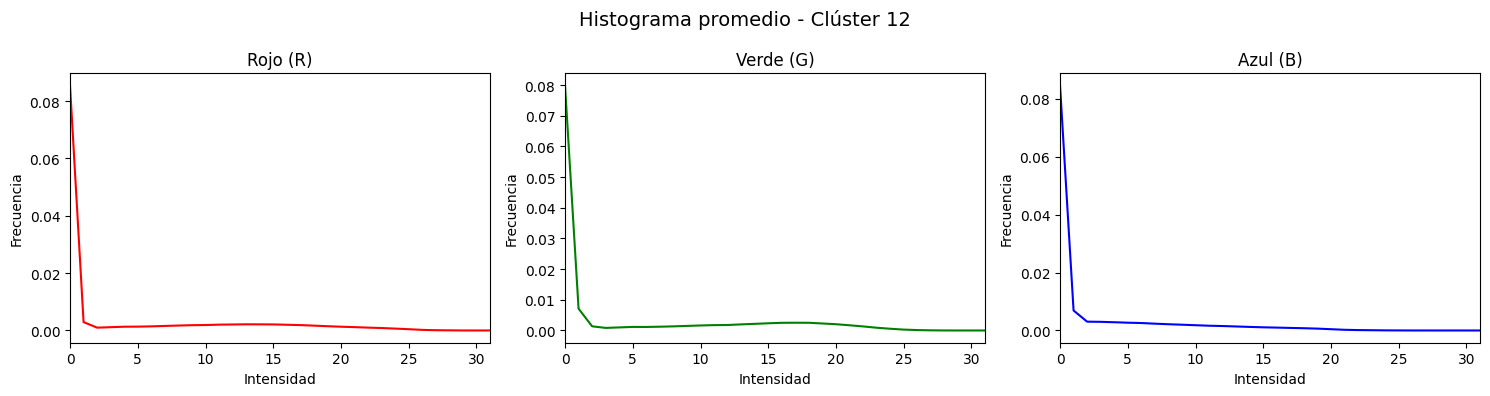

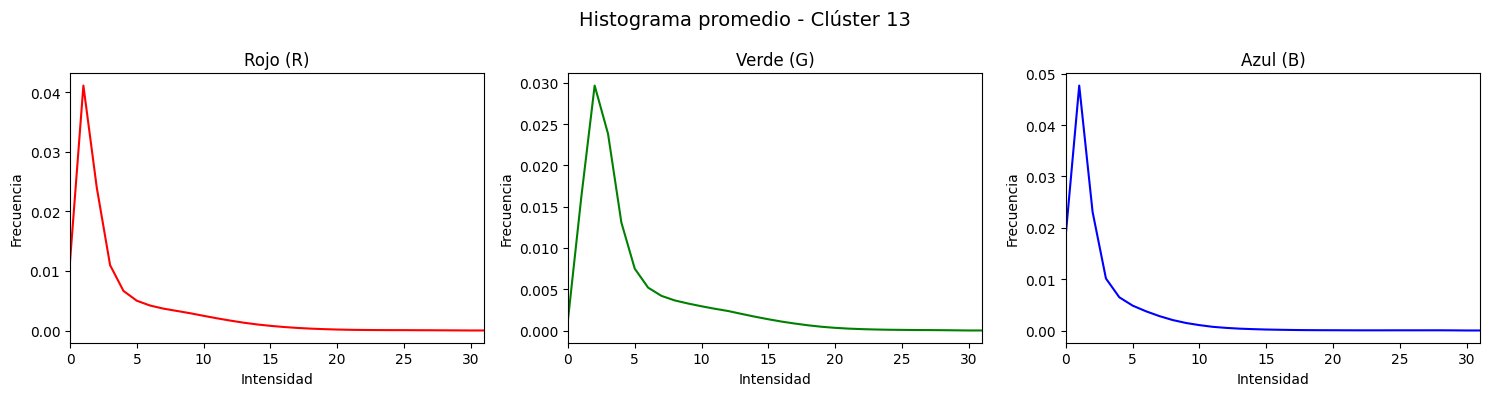

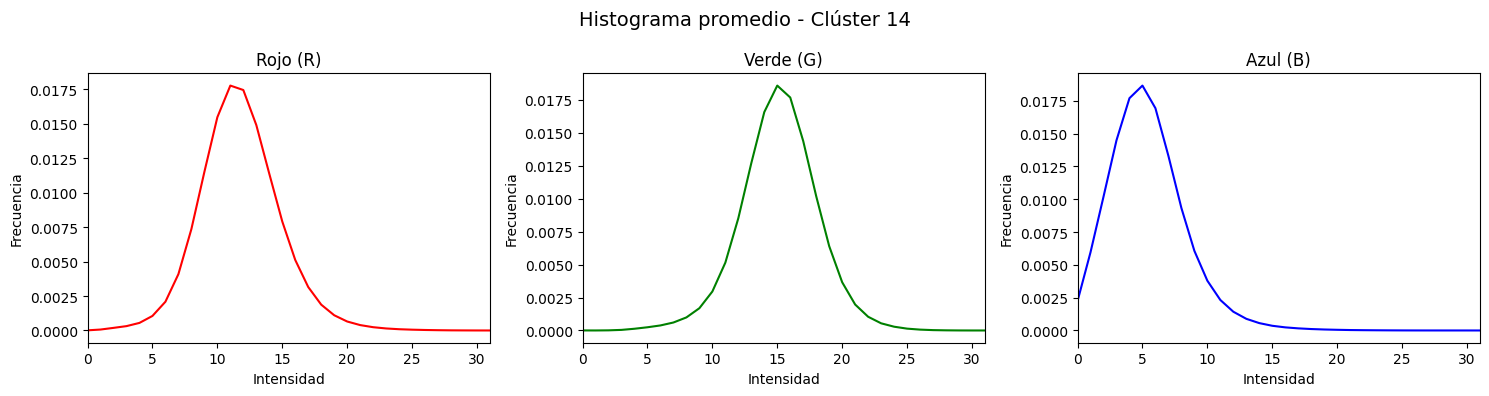

In [29]:
k=15
labels_rgb,modelo_rgb=aplicar_kmeans(X_RGB,k)
visualizar_histogramas_promedio(X_RGB,labels_rgb,32)

c:\Users\EsSe009\citrus3-detector\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Se generaron 88205 parches de 40x40 con stride 10
Se construyó una matriz de características con forma: (88205, 96)


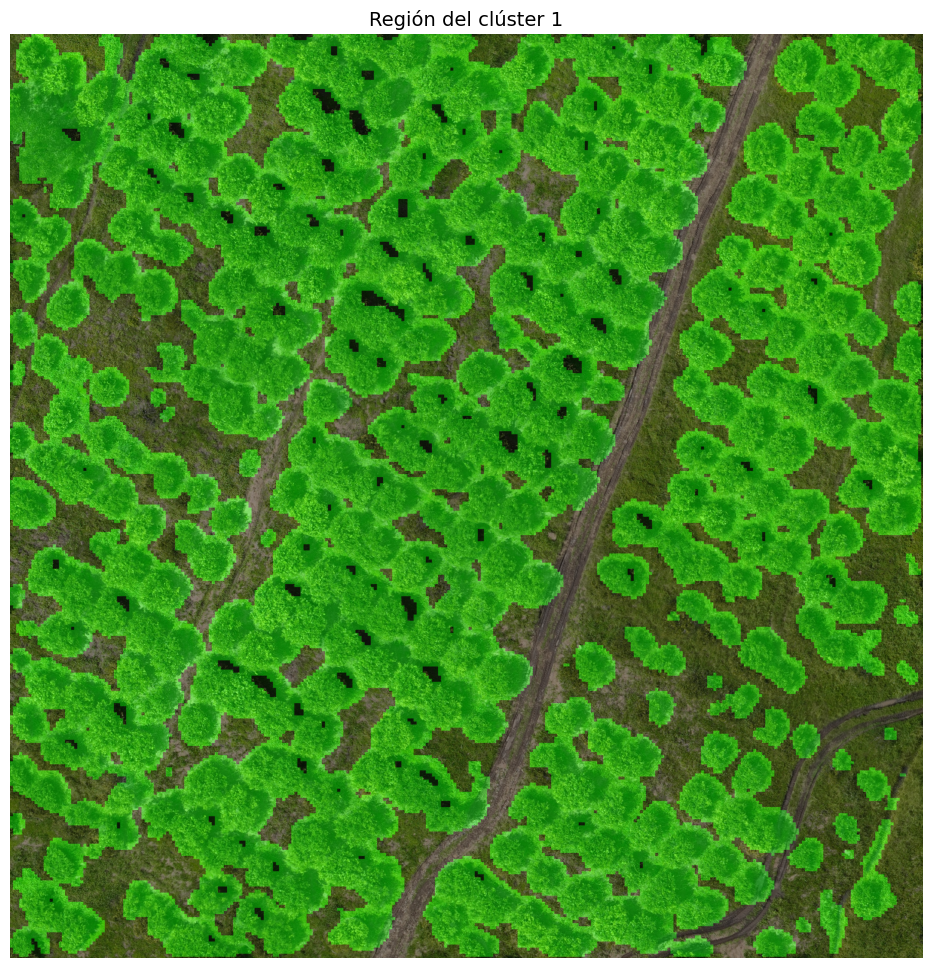

In [31]:
Str=10
Tam=40


for imm in archivos[1:2]:
    imagen_tiff = os.path.join(Ruta,imm)
    with rasterio.open(imagen_tiff) as src:
        imagen = src.read()
        imagen = np.transpose(imagen, (1, 2, 0))  # Reordenar a (alto, ancho, bandas)
        #imagen=cv2.resize(imagen, (imagen.shape[1]*2, imagen.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    #hsv  = cv2.cvtColor(imagen, cv2.COLOR_RGB2HSV)
    parches_i=generar_patches_solapados(imagen,Tam,Str)
    #parches_j=generar_patches_solapados(hsv,Tam,Str)
    Xi=construir_vectores_caracteristicas(parches_i,32)
    #Xj=construir_vectores_caracteristicas_HSV(parches_j,32)
    Xji=Xi

    Etiquetas=reconstruir_mapa_clusters(imagen=imagen,X=Xji,model=modelo_rgb,tamano=Tam,stride=Str,cluster_prioritario=[4,9,5,13],umbral=3)
    visualizar_mapa_reconstruido(imagen,Etiquetas,1,0.4,[0,255,0])

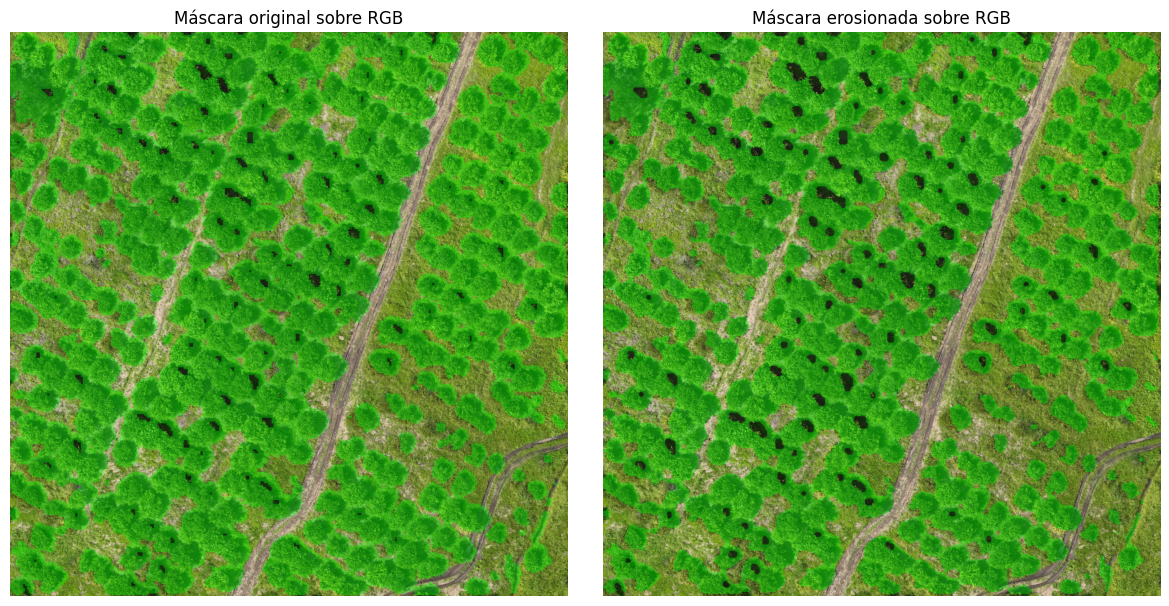

In [32]:
# Supone que ya tienes: imagen (RGB), Etiquetas, y la función erosion_mascara_cluster
kernel_circular = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_cruz = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
mascara = (Etiquetas == 1).astype(np.uint8)
Erosion_masks= [erosion_mascara_cluster(Etiquetas, cluster_id=1, kernel=kernel_cruz,iteraciones=ee) for ee in range(0,12,2)]

imagen2=imagen[:,:,:3]
mascara_erodida=Erosion_masks[4]
# Copias de la imagen para overlay
overlay_original = imagen2.copy()
overlay_erosion = imagen2.copy()

# Color verde en formato RGB
verde = np.array([0, 255, 0], dtype=np.uint8)
alpha = 0.4  # Transparencia

# Aplicar color verde con transparencia en cada máscara
overlay_original[mascara == 1] = (1 - alpha) * overlay_original[mascara == 1] + alpha * verde
overlay_erosion[mascara_erodida == 1] = (1 - alpha) * overlay_erosion[mascara_erodida == 1] + alpha * verde

# Mostrar ambos overlays
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(overlay_original.astype(np.uint8))
plt.title("Máscara original sobre RGB")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_erosion.astype(np.uint8))
plt.title("Máscara erosionada sobre RGB")
plt.axis("off")

plt.tight_layout()
plt.show()

C:\Users\EsSe009\AppData\Local\Temp\ipykernel_35000\1906819913.py:21: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = x - r, y - r


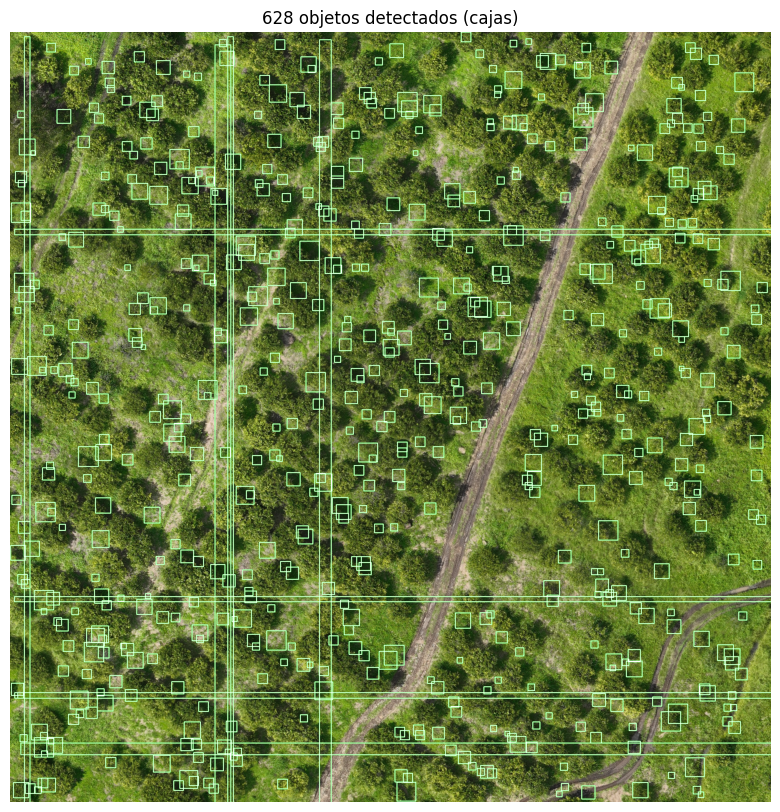

In [33]:
# Asegurar formato correcto: convertir máscara binaria a 8 bits
img = (mascara_erodida > 0).astype(np.uint8) * 255


# Umbral para asegurar imagen binaria
#_, binaria = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Suavizar la imagen para mejorar detección de bordes circulares
#img_blur = cv2.medianBlur(img, 5)
#cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Detección de círculos (mismos parámetros anteriores)
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                           param1=50, param2=12, minRadius=8, maxRadius=40)
imc=imagen.copy()
# Dibujar cajas en lugar de círculos
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        x, y, r = i[0], i[1], i[2]
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r
        cv2.rectangle(imc, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(imc)
plt.title(f"{len(circles[0]) if circles is not None else 0} objetos detectados (cajas)")
plt.axis("off")
plt.show()


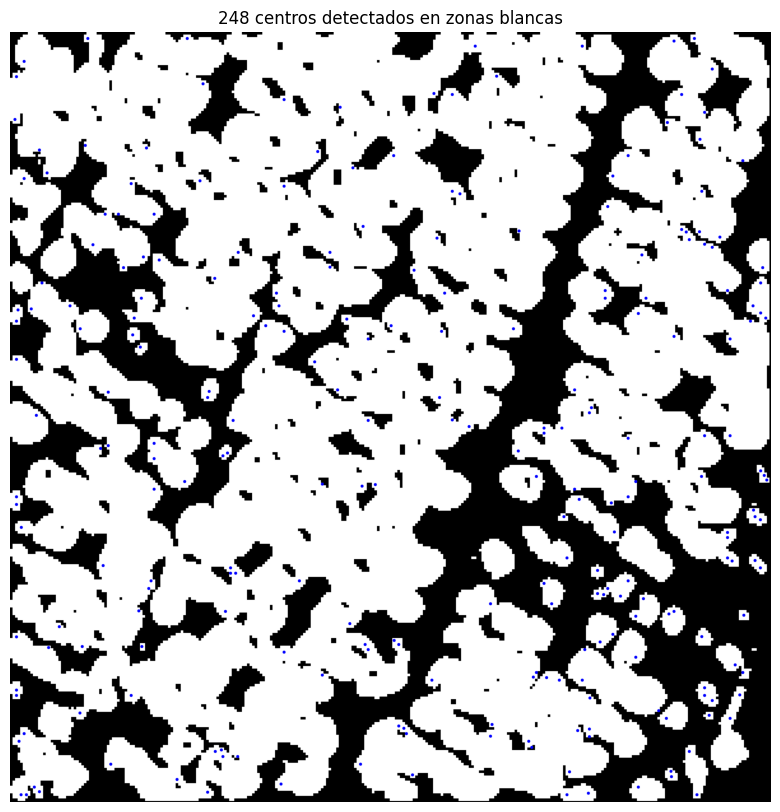

In [34]:

# Crear máscara de zona blanca
mascara = (Etiquetas == 1).astype(np.uint8) * 255

# Aplicar median blur
img_blur = cv2.medianBlur(mascara, 5)

# Detectar círculos SOLO en la zona blanca
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                           param1=50, param2=12, minRadius=8, maxRadius=40)

# Imagen base para graficar centros sobre blanco
resultado = cv2.cvtColor(mascara, cv2.COLOR_GRAY2BGR)

# Lista para contar cuántos círculos válidos se grafican
centros_validos = 0

# Graficar solo los centros detectados DENTRO de la zona blanca
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        x, y = i[0], i[1]
        if mascara[y, x] == 255:  # solo si el centro está en zona blanca
            cv2.circle(resultado, (x, y), 6, (0, 0, 255), -1)
            centros_validos += 1

# Mostrar
plt.figure(figsize=(10, 10))
plt.imshow(resultado)
plt.title(f"{centros_validos} centros detectados en zonas blancas")
plt.axis("off")
plt.show()



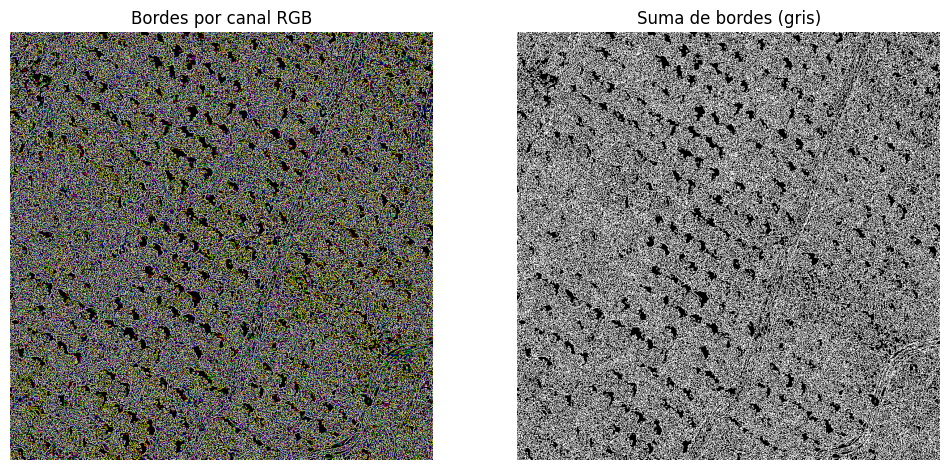

In [26]:
import cv2
import numpy as np

def extraer_bordes_rgb_mas_suma(imagen_rgb, th1=100, th2=150):
    """
    Extrae bordes por canal RGB usando Canny y suma los tres para formar un cuarto canal.

    Parámetros:
    - imagen_rgb: imagen en formato RGB (H x W x 3)
    - th1, th2: umbrales para cv2.Canny

    Retorna:
    - bordes_rgb: imagen con los 3 canales de bordes por R, G y B
    - suma: imagen en escala de grises con la suma de los bordes
    """
    # Separar canales
    R, G, B = imagen_rgb[:, :, 0], imagen_rgb[:, :, 1], imagen_rgb[:, :, 2]

    # Aplicar Canny por canal
    bordes_R = cv2.Canny(R, th1, th2)
    bordes_G = cv2.Canny(G, th1, th2)
    bordes_B = cv2.Canny(B, th1, th2)

    # Apilar en 3 canales
    bordes_rgb = np.stack([bordes_R, bordes_G, bordes_B], axis=2)

    # Sumar los bordes y escalar para evitar saturación
    suma = np.clip(bordes_R.astype(np.uint16) + bordes_G + bordes_B, 0, 255).astype(np.uint8)

    return bordes_rgb, suma

bordes_rgb, suma = extraer_bordes_rgb_mas_suma(imagen)

# Mostrar resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(bordes_rgb)
plt.title("Bordes por canal RGB")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(suma, cmap='gray')
plt.title("Suma de bordes (gris)")
plt.axis("off")
plt.show()


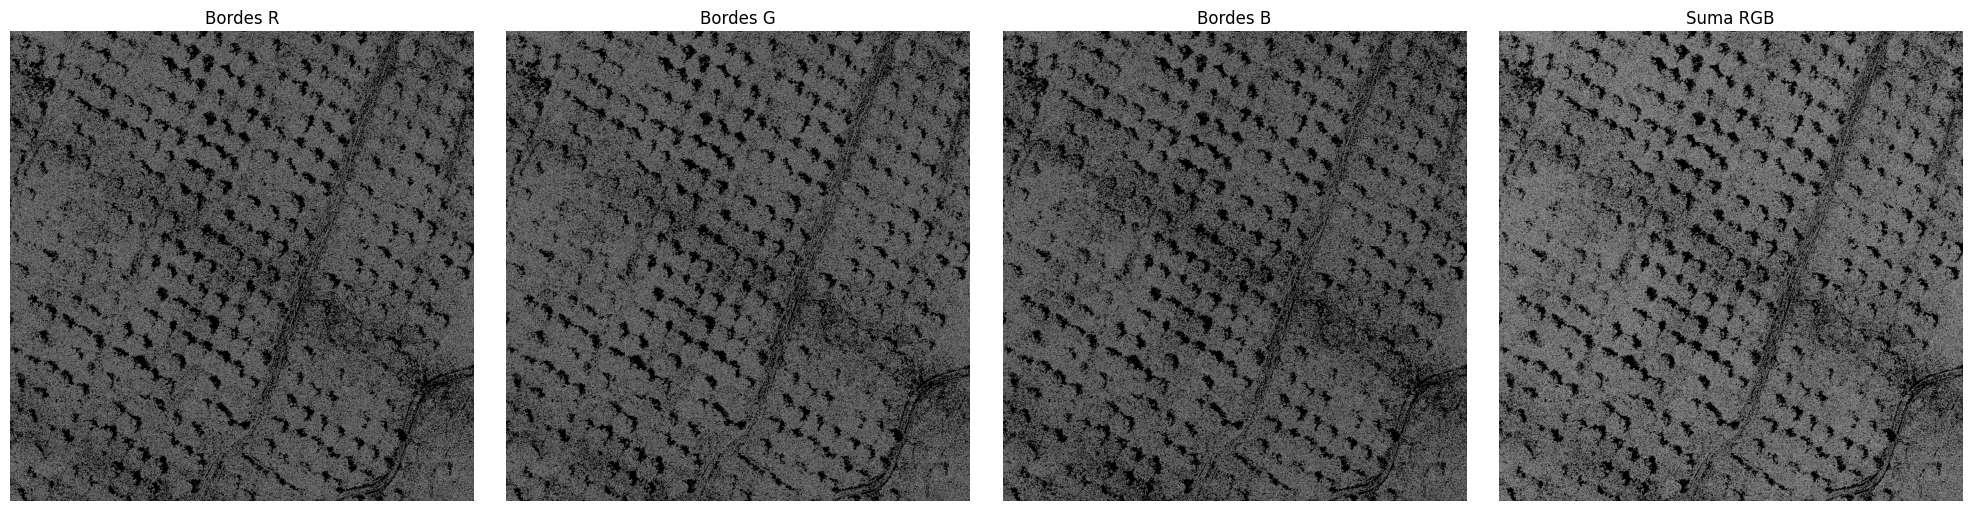

In [37]:
def extraer_bordes_rgb_mas_suma(imagen_rgb, th1=120, th2=150):
    R, G, B = imagen_rgb[:, :, 0], imagen_rgb[:, :, 1], imagen_rgb[:, :, 2]
    bordes_R = cv2.Canny(R, th1, th2)
    bordes_G = cv2.Canny(G, th1, th2)
    bordes_B = cv2.Canny(B, th1, th2)
    suma = np.clip(bordes_R.astype(np.uint16) + bordes_G + bordes_B, 0, 255).astype(np.uint8)
    return bordes_R, bordes_G, bordes_B, suma

# Aplicar la función
bordes_R, bordes_G, bordes_B, suma = extraer_bordes_rgb_mas_suma(imagen)

# Graficar cada canal de bordes por separado
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(bordes_R, cmap='gray')
axes[0].set_title("Bordes R")
axes[0].axis("off")

axes[1].imshow(bordes_G, cmap='gray')
axes[1].set_title("Bordes G")
axes[1].axis("off")

axes[2].imshow(bordes_B, cmap='gray')
axes[2].set_title("Bordes B")
axes[2].axis("off")

axes[3].imshow(suma, cmap='gray')
axes[3].set_title("Suma RGB")
axes[3].axis("off")

plt.tight_layout()
plt.show()